## Import packages

In [19]:
import sys

sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt

## Load image

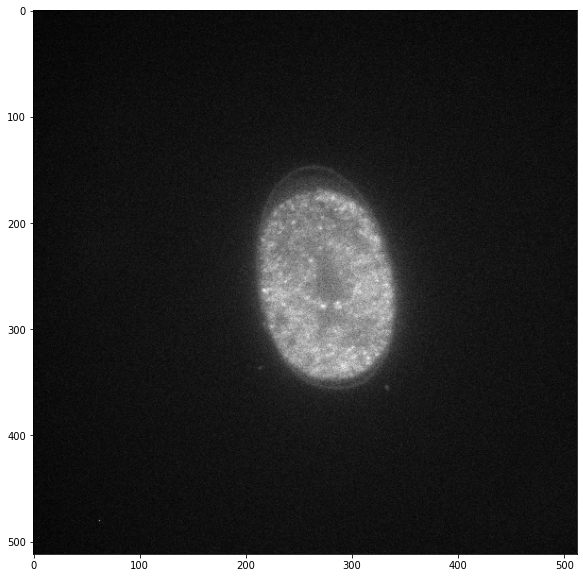

In [20]:
from membranequant.funcs import load_image

file_path = '../test_datasets/dataset1_n2/00/_00_w2488 SP 535-50 Nelio.TIF'
img = load_image(file_path)

%matplotlib inline
plt.imshow(img, cmap='gray')
plt.gcf().set_size_inches(10,10)

## Specify ROI

Using the def_roi function to manually specify an ROI defining the cortex (or region of the cortex to be straightened).

Set periodic=True if the ROI is periodic (i.e. the whole cell circumference).

A new interactive window will open.

In [21]:
from membranequant.roi import def_roi

periodic = False

%matplotlib tk
roi = def_roi(img, spline=False, periodic=periodic)
print(roi.shape)

(4, 2)


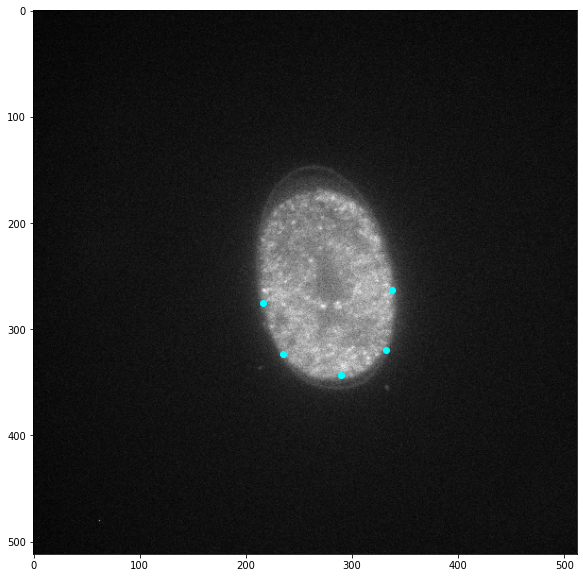

In [9]:
%matplotlib inline
plt.imshow(img, cmap='gray')
plt.scatter(roi[:, 0], roi[:, 1], c='aqua')
plt.gcf().set_size_inches(10,10)

## Fit spline to ROI

Fit a spline to the user inputed points, and interpolate coordinates at pixel-length distances.

NOTE this process can be automatically performed by setting spline to True in the def_roi function.

In [10]:
from scipy.interpolate import splprep, splev, interp1d

# Append the starting x,y coordinates
if periodic:
    x = np.r_[roi[:, 0], roi[0, 0]]
    y = np.r_[roi[:, 1], roi[0, 1]]
else:
    x = roi[:, 0]
    y = roi[:, 1]

# Fit spline
tck, u = splprep([x, y], s=0, per=periodic)

# Evaluate spline at many points
xi, yi = splev(np.linspace(0, 1, 10000), tck)

# Calculate distance between points in pixel units
distances = ((np.diff(xi) ** 2) + (np.diff(yi) ** 2)) ** 0.5
distances_cumsum = np.r_[0, np.cumsum(distances)]

# Calculate total length of spline
total_length = sum(distances)

# Interpolate to one pixel distances
fx, fy = interp1d(distances_cumsum, xi, kind='linear'), interp1d(distances_cumsum, yi, kind='linear')
positions = np.linspace(0, total_length, int(round(total_length)))
xcoors, ycoors = fx(positions), fy(positions)
roi = np.c_[xcoors[:-1], ycoors[:-1]]
print(roi.shape)

(222, 2)


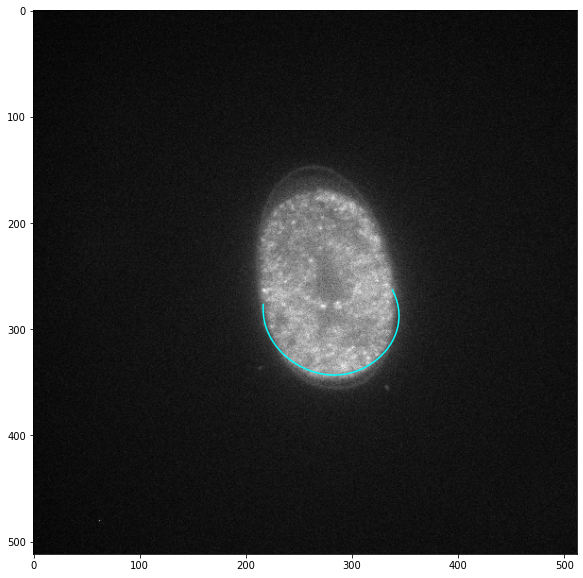

In [14]:
%matplotlib inline
plt.imshow(img, cmap='gray')
plt.plot(roi[:, 0], roi[:, 1], c='aqua')
plt.gcf().set_size_inches(10,10)

## Calculate grid coordinates

Calculate the grid coordinates at which the interpolate image.

Set the thickness parameter to specify the thickness of the resulting straightened image.

In [15]:
thickness = 50

# Calculate grid
xcoors = roi[:, 0]
ycoors = roi[:, 1]
ydiffs = np.diff(ycoors, prepend=ycoors[-1])
xdiffs = np.diff(xcoors, prepend=xcoors[-1])
grad = ydiffs / xdiffs
tangent_grad = -1 / grad
offsets = np.linspace(thickness / 2, -thickness / 2, thickness)
xchange = ((offsets ** 2)[np.newaxis, :] / (1 + tangent_grad ** 2)[:, np.newaxis]) ** 0.5
ychange = xchange / abs(grad)[:, np.newaxis]
gridcoors_x = xcoors[:, np.newaxis] + np.sign(ydiffs)[:, np.newaxis] * np.sign(offsets)[np.newaxis, :] * xchange
gridcoors_y = ycoors[:, np.newaxis] - np.sign(xdiffs)[:, np.newaxis] * np.sign(offsets)[np.newaxis, :] * ychange

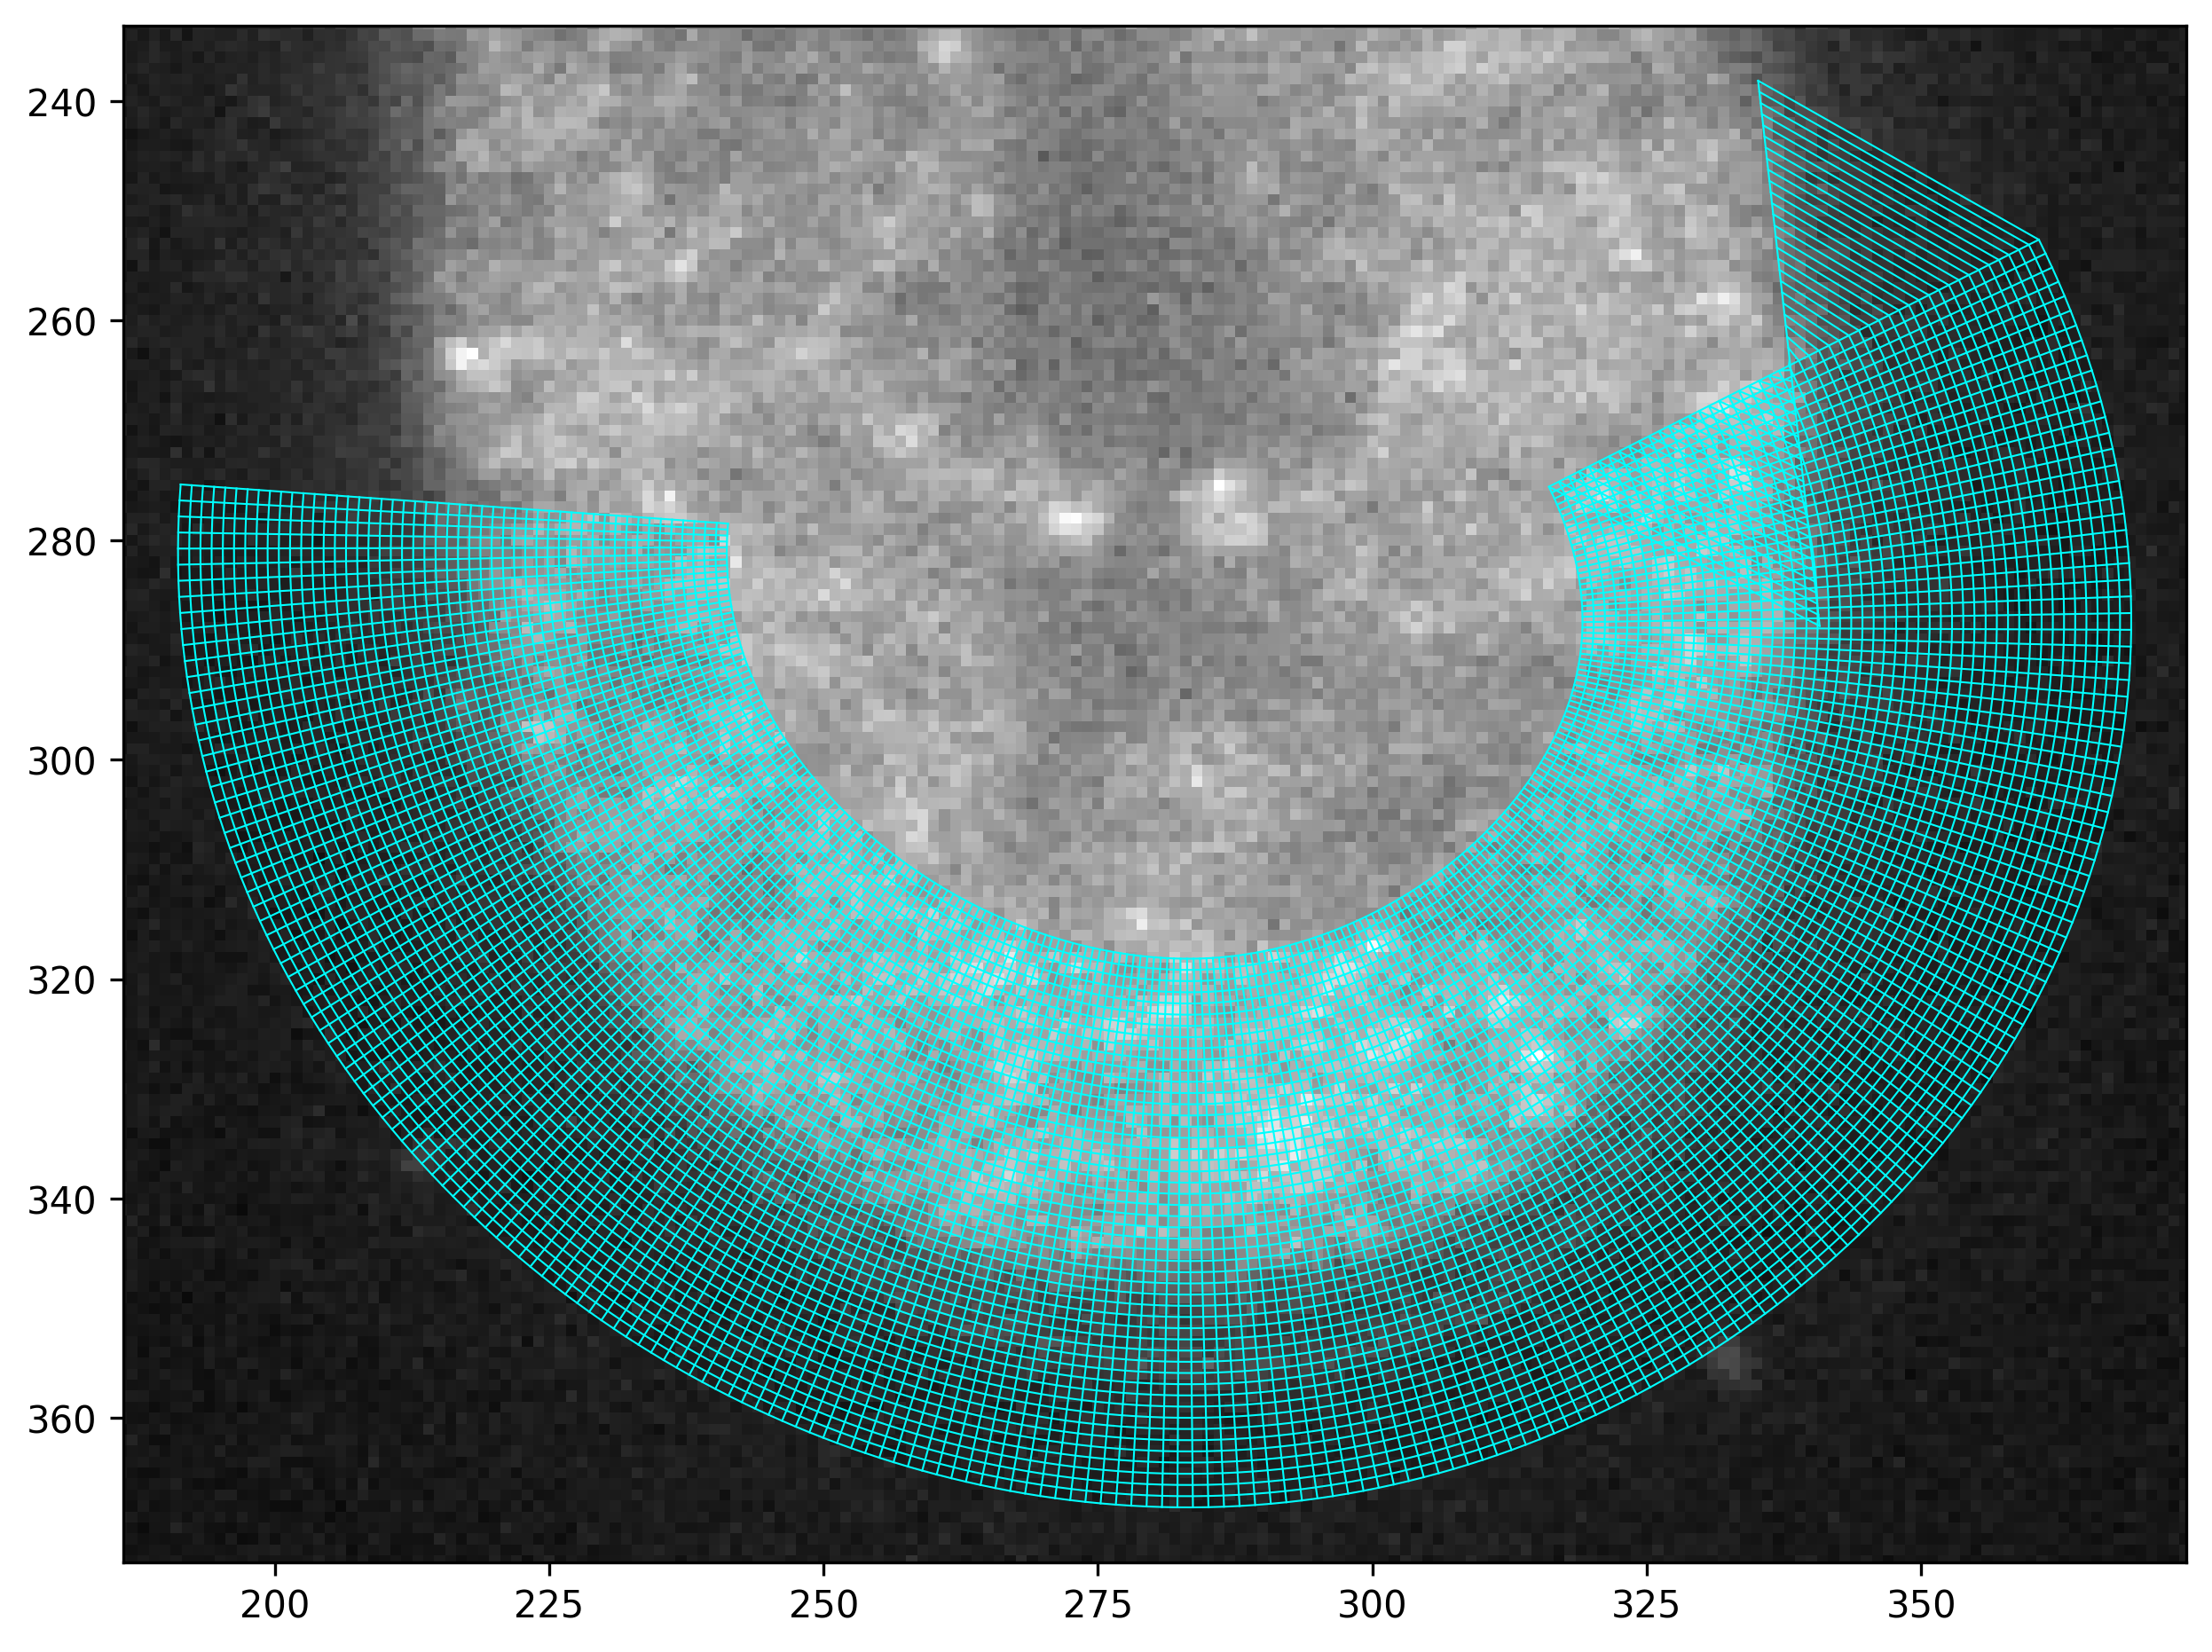

In [16]:
# Plot grid
%matplotlib inline
plt.imshow(img, cmap='gray')
plt.plot(gridcoors_x, gridcoors_y, linewidth=0.5, c='aqua')
plt.plot(gridcoors_x.T, gridcoors_y.T, linewidth=0.5, c='aqua')
plt.xlim(np.min(gridcoors_x) - 5, np.max(gridcoors_x) + 5)
plt.ylim(np.max(gridcoors_y) + 5, np.min(gridcoors_y) - 5)
plt.gcf().set_size_inches(10,10)
plt.gcf().set_dpi(300)

## Get straightened image by interpolation

Using the scipy function map_coordinates to map the image to the above coordinate grid by interpolation, outputting a straightened image of the cell cortex.

Can perform linear interpolation by specifying order = 1, or cubic interpolation by specifying order = 3.

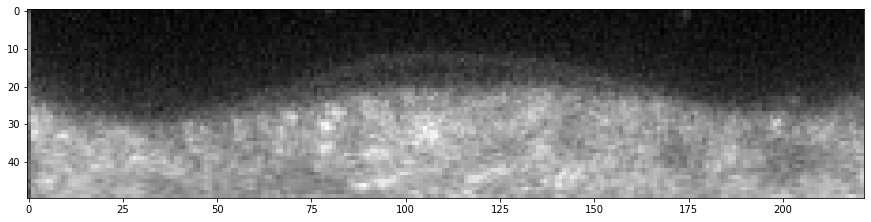

In [17]:
from scipy.ndimage.interpolation import map_coordinates

order = 3
straight_img = map_coordinates(img.T, [gridcoors_x, gridcoors_y], order=3, mode='nearest').T

%matplotlib inline
plt.imshow(straight_img, cmap='gray')
plt.gcf().set_size_inches(15,15)

## Straighten function

The above processes can be performed in a single line using the straighten function:

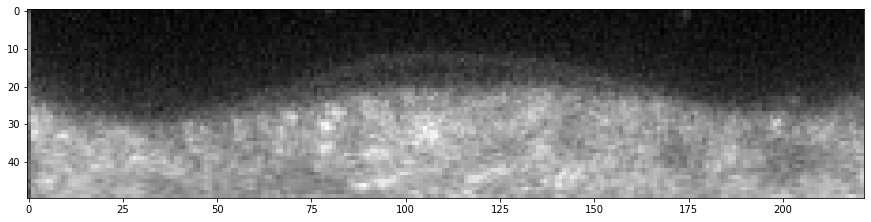

In [18]:
from membranequant.funcs import straighten
straight_img = straighten(img=img, roi=roi, thickness=50, interp='cubic')

%matplotlib inline
plt.imshow(straight_img, cmap='gray')
plt.gcf().set_size_inches(15,15)